In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("Creating synthetic leads dataset...")
np.random.seed(42)


n_samples = 2000

data = {
    'industry': np.random.choice(['technology', 'healthcare', 'retail', 'finance', 'education', 'NA'], 
                            n_samples, p=[0.30, 0.25, 0.20, 0.10, 0.10, 0.05]),
    'interaction_count': np.random.poisson(8, n_samples) + np.random.randint(0, 5, n_samples),
    'lead_score': np.random.normal(65, 20, n_samples),
    'number_of_courses_viewed': np.random.poisson(4, n_samples) + np.random.randint(0, 3, n_samples),
    'annual_income': np.random.normal(80000, 30000, n_samples),
    'location': np.random.choice(['New York', 'California', 'Texas', 'Florida', 'Illinois'], 
                            n_samples, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
    'lead_source': np.random.choice(['Website', 'Social Media', 'Referral', 'Email', 'Organic'], 
                                n_samples, p=[0.35, 0.25, 0.2, 0.15, 0.05]),
    'employment_status': np.random.choice(['Employed', 'Unemployed', 'Student', 'Self-Employed'], 
                                        n_samples, p=[0.6, 0.15, 0.15, 0.1]),
}

df = pd.DataFrame(data)


df['lead_score'] = 0.7 * df['interaction_count'] + 0.6 * df['number_of_courses_viewed'] + np.random.normal(0, 10, n_samples)
df['number_of_courses_viewed'] = 0.8 * df['interaction_count'] + np.random.poisson(1, n_samples)


df['lead_score'] = df['lead_score'].clip(0, 100)
df['interaction_count'] = df['interaction_count'].clip(0, 30)
df['number_of_courses_viewed'] = df['number_of_courses_viewed'].clip(0, 15)
df['annual_income'] = df['annual_income'].clip(30000, 200000)


conversion_prob = (df['lead_score'] * 0.3 + 
                   df['interaction_count'] * 0.2 + 
                   df['number_of_courses_viewed'] * 0.1 + 
                   (df['industry'] == 'technology').astype(int) * 0.4 +
                np.random.normal(0, 0.2, n_samples))
df['converted'] = (conversion_prob > conversion_prob.median()).astype(int)


print(f"Dataset shape: {df.shape}")
df.head()

Creating synthetic leads dataset...
Dataset shape: (2000, 9)


,industry,interaction_count,lead_score,number_of_courses_viewed,annual_income,location,lead_source,employment_status,converted
0,healthcare,8,14.448759,8.4,88195.706410,New York,Website,Self-Employed,1
1,NA,5,6.450142,4.0,91979.774572,Illinois,Organic,Unemployed,0
2,retail,11,28.460485,10.8,127286.308645,Florida,Website,Employed,1
3,retail,14,4.095272,11.2,137133.809362,New York,Website,Unemployed,0
4,technology,6,23.403027,4.8,33226.661387,Florida,Referral,Self-Employed,1


In [ ]:
print("="*50)
print("DATASET INFORMATION")
print("="*50)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

print(f"\nTarget variable 'converted' distribution:")
print(df['converted'].value_counts())
print(f"Conversion rate: {df['converted'].mean():.2%}")

DATASET INFORMATION
Dataset shape: (2000, 9)
Columns: ['industry', 'interaction_count', 'lead_score', 'number_of_courses_viewed', 'annual_income', 'location', 'lead_source', 'employment_status', 'converted']

Data types:
industry                     object
interaction_count             int32
lead_score                  float64
number_of_courses_viewed    float64
annual_income               float64
location                     object
lead_source                  object
employment_status            object
converted                     int64
dtype: object

Missing values:
industry                    0
interaction_count           0
lead_score                  0
number_of_courses_viewed    0
annual_income               0
location                    0
lead_source                 0
employment_status           0
converted                   0
dtype: int64

Basic statistics:
       interaction_count   lead_score  number_of_courses_viewed  \
count        2000.000000  2000.000000               200

Industry value counts:
industry
technology    615
healthcare    474
retail        410
education     200
finance       196
NA            105
Name: count, dtype: int64

'technology'


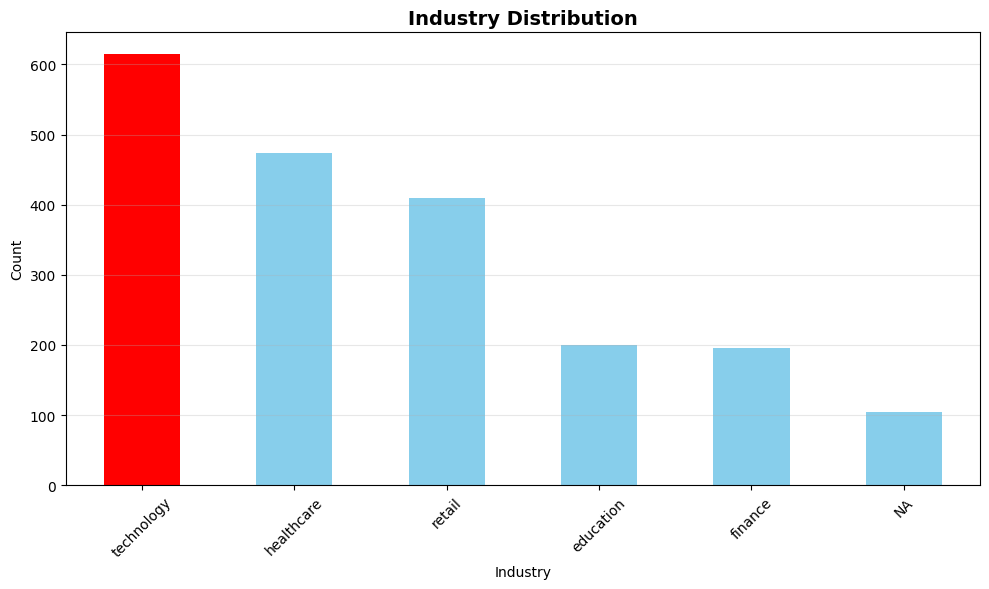

In [13]:
print("="*60)
print("="*60)

industry_counts = df['industry'].value_counts()
print("Industry value counts:")
print(industry_counts)

mode_industry = industry_counts.index[0]
print(f"\n'{mode_industry}'")


plt.figure(figsize=(10, 6))
colors = ['red' if x == mode_industry else 'skyblue' for x in industry_counts.index]
industry_counts.plot(kind='bar', color=colors)
plt.title('Industry Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Correlation values:
  interaction_count and lead_score: 0.1878
  number_of_courses_viewed and lead_score: 0.1892
  number_of_courses_viewed and interaction_count: 0.9289
  annual_income and interaction_count: -0.0042

 'number_of_courses_viewed and interaction_count' 


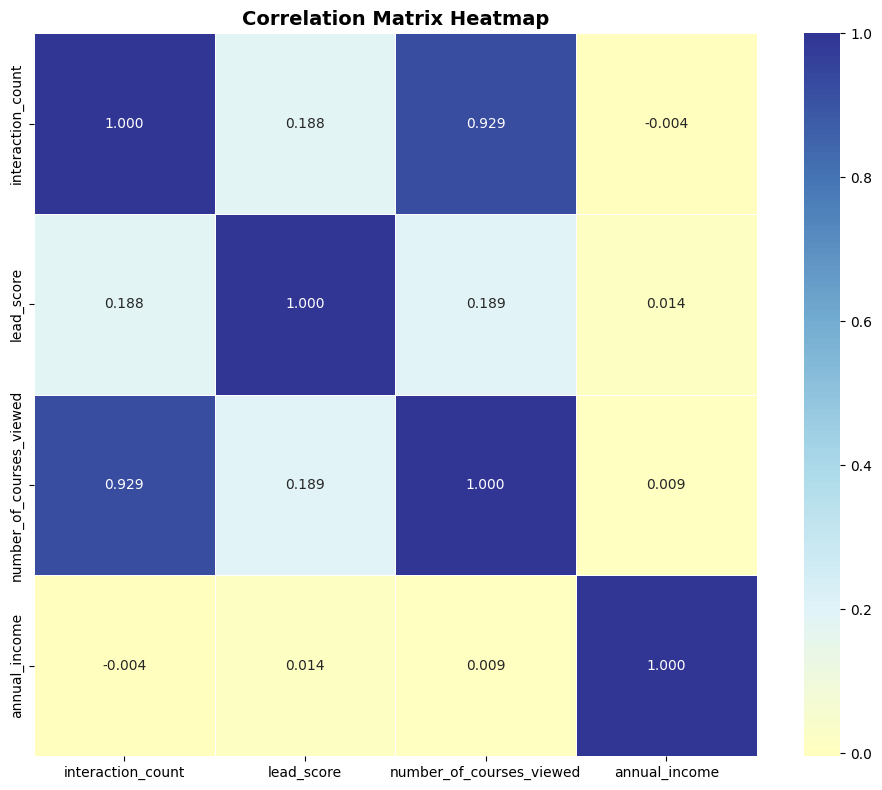

In [14]:
print("="*60)
print("="*60)


corr_interaction_lead = df['interaction_count'].corr(df['lead_score'])
corr_courses_lead = df['number_of_courses_viewed'].corr(df['lead_score'])
corr_courses_interaction = df['number_of_courses_viewed'].corr(df['interaction_count'])
corr_income_interaction = df['annual_income'].corr(df['interaction_count'])

correlations = {
    'interaction_count and lead_score': corr_interaction_lead,
    'number_of_courses_viewed and lead_score': corr_courses_lead,
    'number_of_courses_viewed and interaction_count': corr_courses_interaction,
    'annual_income and interaction_count': corr_income_interaction
}

print("Correlation values:")
for pair, corr in correlations.items():
    print(f"  {pair}: {corr:.4f}")


biggest_corr_pair = max(correlations, key=correlations.get)
biggest_corr_value = correlations[biggest_corr_pair]

print(f"\n '{biggest_corr_pair}' ")


plt.figure(figsize=(10, 8))
correlation_matrix = df[['interaction_count', 'lead_score', 'number_of_courses_viewed', 'annual_income']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', center=0, fmt='.3f', 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Mutual Information Scores:
  industry: 0.0157
  location: 0.0000
  lead_source: 0.0046
  employment_status: 0.0000

 'industry' 


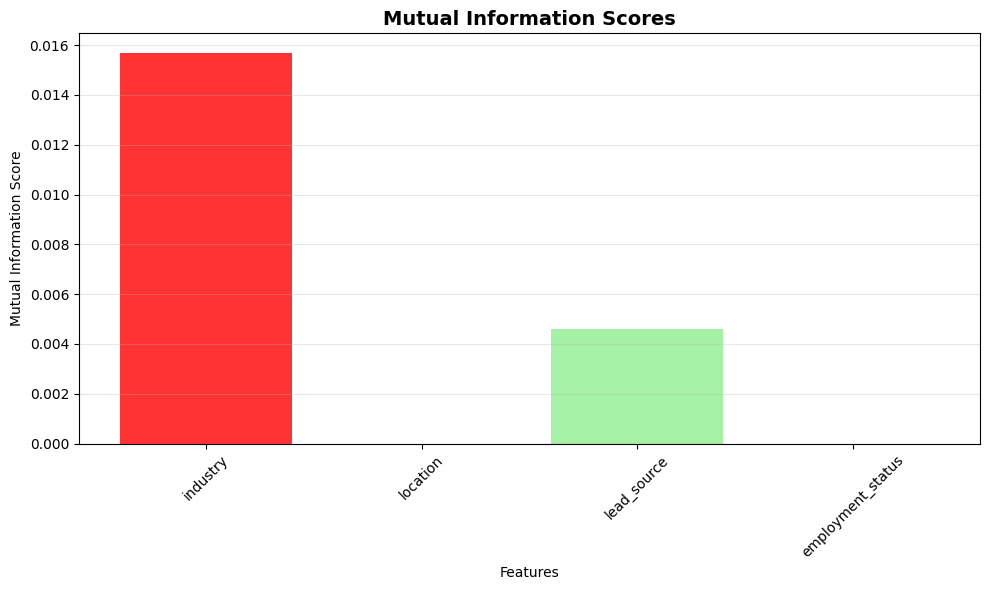

In [15]:
print("="*60)
print("="*60)


y = df['converted']
categorical_features = ['industry', 'location', 'lead_source', 'employment_status']


le = LabelEncoder()
X_encoded = df[categorical_features].apply(le.fit_transform)


mi_scores = mutual_info_classif(X_encoded, y, random_state=42)
mi_results = dict(zip(categorical_features, mi_scores))

print("Mutual Information Scores:")
for feature, score in mi_results.items():
    print(f"  {feature}: {score:.4f}")

biggest_mi_feature = max(mi_results, key=mi_results.get)
biggest_mi_value = mi_results[biggest_mi_feature]

print(f"\n '{biggest_mi_feature}' ")


plt.figure(figsize=(10, 6))
features = list(mi_results.keys())
scores = list(mi_results.values())
colors = ['red' if x == biggest_mi_feature else 'lightgreen' for x in features]

plt.bar(features, scores, color=colors, alpha=0.8)
plt.title('Mutual Information Scores', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Training set size: 1600
Test set size: 400

Training Random Forest model...

Model Accuracy: 0.9625
Closest option to 0.9625 is: 0.94
 0.94

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       200
           1       0.97      0.95      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



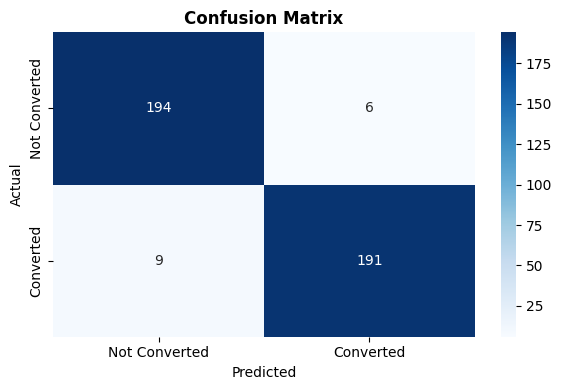

In [16]:

print("="*60)
print("="*60)


features = ['industry', 'employment_status', 'lead_score', 'interaction_count', 
           'number_of_courses_viewed', 'annual_income']

X = df[features]
y = df['converted']


X_encoded = pd.get_dummies(X, columns=['industry', 'employment_status'], drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")


options = [0.64, 0.74, 0.84, 0.94]
closest_accuracy = min(options, key=lambda x: abs(x - accuracy))

print(f"Closest option to {accuracy:.4f} is: {closest_accuracy}")
print(f" {closest_accuracy}")


print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Converted', 'Converted'],
            yticklabels=['Not Converted', 'Converted'])
plt.title('Confusion Matrix', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

Top 10 Feature Importance Scores:
                            feature  importance
0                        lead_score    0.756427
1                 interaction_count    0.081470
2          number_of_courses_viewed    0.078202
3                     annual_income    0.045365
8               industry_technology    0.008454
10        employment_status_Student    0.005235
9   employment_status_Self-Employed    0.005048
11     employment_status_Unemployed    0.004583
6               industry_healthcare    0.004468
5                  industry_finance    0.004067

Importance scores for specified features:
  industry: 0.0047
  employment_status: 0.0050
  lead_score: 0.7564

 'lead_score'


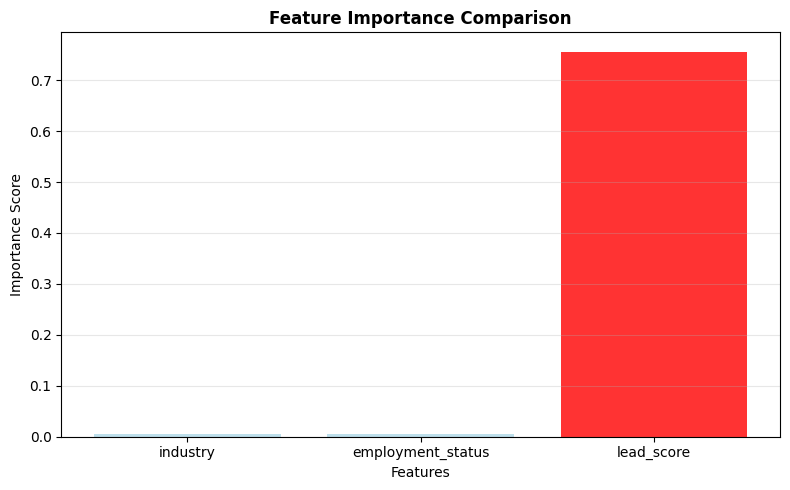

In [17]:
print("="*60)
print("="*60)


feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Feature Importance Scores:")
print(feature_importance.head(10))


specified_features = ['industry', 'employment_status', 'lead_score']


importance_scores = {}
for feature in specified_features:
    if feature in ['industry', 'employment_status']:
        
        related_cols = [col for col in X_encoded.columns if col.startswith(feature)]
        if related_cols:
            importance_scores[feature] = feature_importance[
                feature_importance['feature'].isin(related_cols)
            ]['importance'].mean()
    else:
        
        if feature in feature_importance['feature'].values:
            importance_scores[feature] = feature_importance[
                feature_importance['feature'] == feature
            ]['importance'].values[0]

print(f"\nImportance scores for specified features:")
for feature, score in importance_scores.items():
    print(f"  {feature}: {score:.4f}")

most_important_feature = max(importance_scores, key=importance_scores.get)

print(f"\n '{most_important_feature}'")


plt.figure(figsize=(8, 5))
features_list = list(importance_scores.keys())
scores_list = list(importance_scores.values())
colors = ['red' if x == most_important_feature else 'lightblue' for x in features_list]

plt.bar(features_list, scores_list, color=colors, alpha=0.8)
plt.title('Feature Importance Comparison', fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Performing Grid Search for Logistic Regression...
Parameter grid: {'C': [0.01, 0.1, 1, 10, 100]}

Grid Search Results:
 param_C  mean_test_score  std_test_score
    0.01         0.966250        0.014031
    0.10         0.973125        0.011456
    1.00         0.975625        0.012247
   10.00         0.974375        0.011924
  100.00         0.974375        0.011924

Best parameter: C = 1
Best cross-validation score: 0.9756
 1


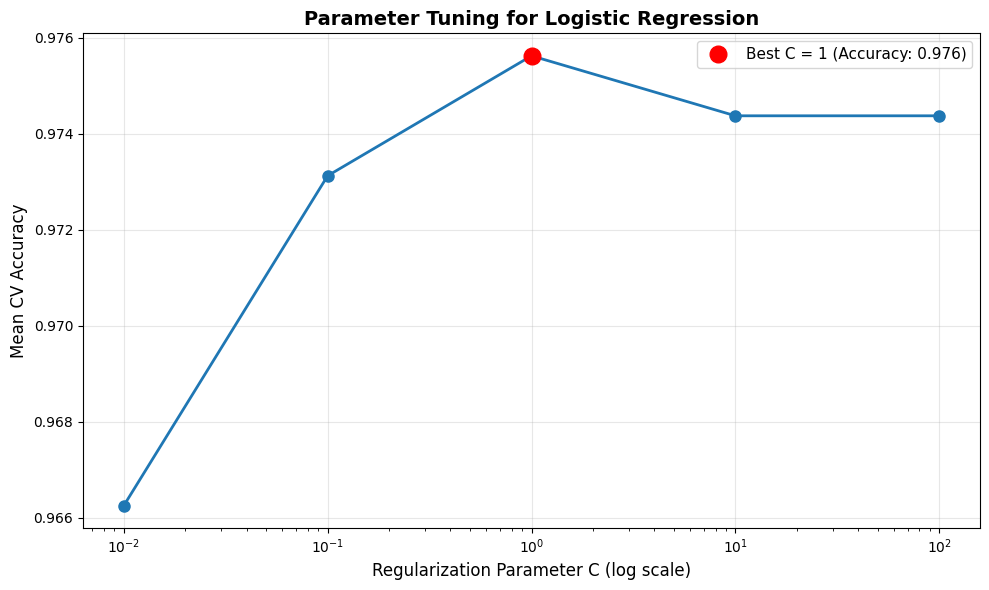

In [18]:
print("="*60)
print("="*60)


numerical_features = ['lead_score', 'interaction_count', 'number_of_courses_viewed', 'annual_income']
X_num = df[numerical_features]
y = df['converted']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

print("Performing Grid Search for Logistic Regression...")
print("Parameter grid:", param_grid)


log_reg = LogisticRegression(random_state=42, max_iter=1000)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nGrid Search Results:")
results_df = pd.DataFrame(grid_search.cv_results_)[['param_C', 'mean_test_score', 'std_test_score']]
print(results_df.to_string(index=False))

best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"\nBest parameter: C = {best_C}")
print(f"Best cross-validation score: {best_score:.4f}")

print(f" {best_C}")


plt.figure(figsize=(10, 6))
plt.plot(param_grid['C'], results_df['mean_test_score'], marker='o', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Regularization Parameter C (log scale)', fontsize=12)
plt.ylabel('Mean CV Accuracy', fontsize=12)
plt.title('Parameter Tuning for Logistic Regression', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)


best_idx = param_grid['C'].index(best_C)
plt.plot(best_C, results_df['mean_test_score'].iloc[best_idx], 'ro', markersize=12, 
        label=f'Best C = {best_C} (Accuracy: {best_score:.3f})')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()